# Libraries

**Summary:** SHAP (SHapley Additive exPlanations) was introduced in 2017 by Lundberg and Lee and has been widely used by data scientists to explain predictive models through computing the contribution of each feature to a prediction. The SHAP summary plot is an interesting plot which shows both contribution of a feature in a prediction and its directionality (how it moves the target needle). 


- With this code  all valuable insights from a SHAP summary plot into a data structure (e.g., pandas DataFrame) which allows to better explain predictive models. Follow below example:


**References**

Lundberg, S. M., & Lee, S. I. (2017). A unified approach to interpreting model predictions. Advances in neural information processing systems, 30.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Built-in libraries
#
import numpy    as np
import pandas   as pd
import shap
import scipy


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import matplotlib.pyplot as plt


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import r2_score


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# XGboost library
#
import xgboost as xgb

# Import Data - Data Preparation


Boston Housing Dataset consists of 506 records which can be used to make a model to predict median home price (in thousands)

In [3]:
#Load data
#
X, Y = shap.datasets.boston()

# Split data - Training/Testing datasets

In [4]:
# Training/Testing datasets
#
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)


trainX.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
477,15.02340,0.0,18.10,0.0,0.6140,5.304,97.3,2.1007,24.0,666.0,20.2,349.48,24.91
15,0.62739,0.0,8.14,0.0,0.5380,5.834,56.5,4.4986,4.0,307.0,21.0,395.62,8.47
332,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
423,7.05042,0.0,18.10,0.0,0.6140,6.103,85.1,2.0218,24.0,666.0,20.2,2.52,23.29
19,0.72580,0.0,8.14,0.0,0.5380,5.727,69.5,3.7965,4.0,307.0,21.0,390.95,11.28


# Prediction Model


## Setup model

In [5]:
# XGBoost model
#
model = xgb.XGBRegressor(n_estimators = 20)


# Training process

In [6]:
model.fit(trainX, trainY);

#
print('[INFO] Evaluation performance')
print(30*'-')
print("Training R2 Score: %.3f" % r2_score(trainY, model.predict(trainX)))
print("Testing R2 Score:  %.3f" % r2_score(testY,  model.predict(testX)))

[INFO] Evaluation performance
------------------------------
Training R2 Score: 0.993
Testing R2 Score:  0.906


# SHAP Summary Plot

In [7]:
# Tree explainer
#
explainer = shap.TreeExplainer( model )

# Calculate SHAP values
#
shap_values = explainer.shap_values( trainX )

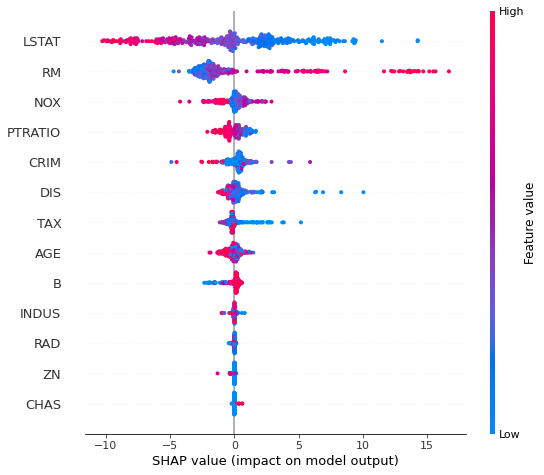

In [8]:
fig = plt.figure(figsize=(30, 30))

shap.summary_plot(shap_values, features=trainX, feature_names=trainX.columns, show=False)
plt.tight_layout()

**Findings:** The following conclusions can be drawn from LSTAT:

- LSTAT is ranked as the most important feature in the predictive model

- For low values of LSTAT is low (blue dots), the target is increased (Blue points are on the right side of y-axis). Note that, on the right side all points are blue (color impurity is zero)

- High LSTAT (red) , to some extent, tends to decrease target (red points are on the left side of the y-axis). Also note that red points on the left side are mixed with blue points (color impurity is not zero)

# Converting Insights from SHAP Summary Plot into a Pandas DataFrame

extract_shap_insights function works similar to shap’s summary plot function, but it returns a DataFrame which contains all information in the plot. Let us review first row which corresponds to the feature LSTAT:

- **relative_impact:** DataFrame is sorted by relative_impact. Similar to shap plot, relative_impact of LSTAT and CHAS are the highest and lowest respectively. Order of other features are the same as shap plot

- **upgrading_impact:** indicates the order of features in upgrading target considering concentration, distribution, and sign of points on the right side of the plot.

- **feature_direction_for_upgrading:** For either low or high values, this feature has upgrading effect on the target. For LSTAT this value is Low.

- **upgrading_impurity:** value varies between zero and one. Low LSTAT instance have upgrading effect on the target

- **downgrading_impact:** suggests the order of features in downgrading target considering concentration, distribution, and sign of points on the left side of the plot

- **feature_direction_for_downgrading:** implies that a feature has a downgrading effect on the target when the value of the feature is either low or high. For LSTAT this value is High but, as it can be seen below, the impurity is not zero.

- **downgrading_impurity:** For LSTAT instance this value is not zero which means, on the downgrading side of the plot, LSTAT feature takes both negative and positive values.


In [9]:
def Pos_Neg(x):
    try:
        if x>0:
            return "High"
        elif x<0:
            return "Low"
        else:
            return "Neutral"
    except:
        return None
    
def general_normalizer(x,data_scale,target_scale):
    try:
        return (target_scale[1]-target_scale[0])*((x-data_scale[0])/(data_scale[1]-data_scale[0]))+target_scale[0]
    except:
        return None

def sign_function(x):
    try:
        if x>0:
            return 1
        elif x<0:
            return -1
        else:
            return 0
    except:
        return None

def shannon(a_list):
    return scipy.stats.entropy(pd.Series(a_list).value_counts())

def extract_shap_insights(df_shap, df_features):
    
    df_shap=df_shap.reset_index(drop=True)
    df_features=df_features.reset_index(drop=True)
    
    df_shap=df_shap.rename(columns=dict(zip(df_shap.columns.tolist(),["shap_"+c for c in df_shap.columns.tolist()])))
    df_features=df_features.rename(columns=dict(zip(df_features.columns.tolist(),["feature_"+c for c in df_features.columns.tolist()])))
    
    for c in df_features.columns:
        min_c=df_features[c].min()
        max_c=df_features[c].max()
        df_features[c]=df_features[c].apply(lambda x: general_normalizer(x,[min_c,max_c],[-1,1]))
    
    concated_shap=pd.concat([df_shap,df_features],axis=1)
    
    
    SHAP_columns=list(set([c.replace("shap_","").replace("feature_","") for c in concated_shap.columns]))
    SHAP = pd.DataFrame(index=SHAP_columns,columns=["relative_impact","upgrading_impact","upgrading_impurity","downgrading_impact","downgrading_impurity"])
    
    for ind in SHAP.index:
        SHAP.loc[ind,"relative_impact"]=concated_shap["shap_"+ind].abs().mean()
        shap_ind="shap_"+ind
        feat_ind="feature_"+ind
        sign_feat="sign_"+ind
        temp_data=concated_shap[[shap_ind,feat_ind]].copy()
        temp_data["product"]=temp_data[shap_ind].abs()*temp_data[feat_ind]
        temp_data[sign_feat]=temp_data[feat_ind].apply(lambda x: sign_function(x))
        SHAP.loc[ind,"upgrading_impact"]=temp_data[temp_data[shap_ind]>0]["product"].sum()
        SHAP.loc[ind,"upgrading_impurity"]=shannon(temp_data[temp_data[shap_ind]>0][sign_feat])
        SHAP.loc[ind,"downgrading_impact"]=temp_data[temp_data[shap_ind]<0]["product"].sum()
        SHAP.loc[ind,"downgrading_impurity"]=shannon(temp_data[temp_data[shap_ind]<0][sign_feat])
        del temp_data
    
    SHAP["feature_direction_for_upgrading"]=SHAP["upgrading_impact"].apply(lambda x: Pos_Neg(x))
    SHAP["feature_direction_for_downgrading"]=SHAP["downgrading_impact"].apply(lambda x: Pos_Neg(x))
    SHAP["upgrading_impact"]=SHAP["upgrading_impact"].abs()
    SHAP["downgrading_impact"]=SHAP["downgrading_impact"].abs()
    
    SHAP=SHAP[['relative_impact', 'upgrading_impact', 'feature_direction_for_upgrading','upgrading_impurity','downgrading_impact', 'feature_direction_for_downgrading','downgrading_impurity']]
    
    SHAP=SHAP.sort_values(by="relative_impact",ascending=False)
    
    return SHAP

In [10]:
shap_values_df=pd.DataFrame(data    = shap_values, 
                            columns = trainX.columns.tolist())

extract_shap_insights(shap_values_df, trainX)

,relative_impact,upgrading_impact,feature_direction_for_upgrading,upgrading_impurity,downgrading_impact,feature_direction_for_downgrading,downgrading_impurity
LSTAT,3.80635,594.157,Low,0,76.0844,High,0.594543
RM,3.01383,320.489,High,0,94.0625,Low,0.616474
NOX,0.589823,27.4943,Low,0.319057,37.304,High,0.692013
PTRATIO,0.582071,40.1348,Low,0.692979,77.0669,High,0
CRIM,0.562996,149.299,Low,0,38.9028,Low,0.154076
DIS,0.487293,104.064,Low,0.0304574,8.31939,Low,0.562335
TAX,0.378909,59.769,Low,0.169658,18.196,Low,0.618371
AGE,0.359301,3.04624,Low,0.687228,71.796,High,0.236858
B,0.285125,57.6179,High,0,17.9324,Low,0.66231
INDUS,0.0716665,4.8243,Low,0.693058,0.0588231,High,0.538126
